# TMT Analysis Automation - All Scenarios

## 📋 Overview
This notebook reads the **original data** from `data/raw/automation_results.json` and **computes the TMT (Total Miscoordination Time) for each individual scenario** across the **68 scenarios** in the protection system. It includes detailed analysis, comprehensive tables, focused charts, and statistics from source data.

## 🎯 Main Objectives
1. **Load original data** - Read `automation_results.json` directly
2. **Compute TMT from scratch** - Process each relay pair to obtain true TMT
3. **Show per-scenario TMT** - Complete table with individually computed values
4. **Visualize TMT by scenario** - Bar chart with performance-based colors
5. **Identify problematic scenarios** - Distribution analysis and critical cases

## 📊 Analysis Contents
- **Original data processed** from `automation_results.json`
- **TMT computed** for each of the 68 scenarios
- **Complete table** sorted by TMT with detailed statistics
- **Individual chart** with colors: Red (worse), Blue (perfect), Green (better)
- **Full statistical analysis** from source data
- **Automatic detection** of problematic scenarios (TMT > 0)


In [1]:
## 1️⃣ Setup and Preparation
# Required libraries
import os
import json
from pathlib import Path
from IPython.display import display, Markdown
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Project paths
project_root = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG")
plots_dir = project_root / "results" / "plots" / "tmt_analysis"
tables_dir = project_root / "results" / "tables"
raw_data_file = project_root / "data" / "raw" / "automation_results.json"

print(f"📁 Project directory: {project_root}")
print(f"📊 Plots directory: {plots_dir}")
print(f"📄 Raw data file: {raw_data_file}")
print(f"✅ Raw data exists: {raw_data_file.exists()}")

# TMT metrics from relay pairs
def calculate_tmt_metrics(pairs, cti=0.2):
    """Compute TMT metrics for a set of relay pairs."""
    if not pairs:
        return {
            'total_pairs': 0,
            'tmt_signed': 0.0,
            'tmt_magnitude': 0.0,
            'coordination_percentage': 0.0,
            'mean_dt': 0.0,
            'std_dt': 0.0,
            'min_dt': 0.0,
            'max_dt': 0.0
        }
    
    dt_values = []
    coordinated_pairs = 0
    
    for pair in pairs:
        main_relay = pair.get('main_relay', {})
        backup_relay = pair.get('backup_relay', {})
        
        time_main = main_relay.get('Time_out', 0)
        time_backup = backup_relay.get('Time_out', 0)
        
        if isinstance(time_main, (int, float)) and isinstance(time_backup, (int, float)):
            dt = (time_backup - time_main) - cti
            dt_values.append(dt)
            
            if dt >= 0:
                coordinated_pairs += 1
    
    if not dt_values:
        return {
            'total_pairs': len(pairs),
            'tmt_signed': 0.0,
            'tmt_magnitude': 0.0,
            'coordination_percentage': 0.0,
            'mean_dt': 0.0,
            'std_dt': 0.0,
            'min_dt': 0.0,
            'max_dt': 0.0
        }
    
    # Compute TMT (signed and magnitude)
    tmt_signed = sum(dt for dt in dt_values if dt < 0)
    tmt_magnitude = sum(abs(dt) for dt in dt_values if dt < 0)
    
    # Coordination percentage
    coordination_percentage = (coordinated_pairs / len(dt_values)) * 100 if dt_values else 0
    
    # DT statistics
    mean_dt = sum(dt_values) / len(dt_values)
    variance = sum((dt - mean_dt) ** 2 for dt in dt_values) / len(dt_values)
    std_dt = variance ** 0.5
    min_dt = min(dt_values)
    max_dt = max(dt_values)
    
    return {
        'total_pairs': len(pairs),
        'tmt_signed': tmt_signed,
        'tmt_magnitude': tmt_magnitude,
        'coordination_percentage': coordination_percentage,
        'mean_dt': mean_dt,
        'std_dt': std_dt,
        'min_dt': min_dt,
        'max_dt': max_dt
    }

# Load original data and compute TMT
if raw_data_file.exists():
    print(f"📊 Loading original data from: {raw_data_file.name}")
    with open(raw_data_file, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    print(f"📋 Total relay pairs loaded: {len(raw_data)}")
    
    # Group by scenario
    scenarios = defaultdict(list)
    for pair in raw_data:
        scenario_id = pair.get('scenario_id')
        if scenario_id:
            scenarios[scenario_id].append(pair)
    
    print(f"📊 Total scenarios found: {len(scenarios)}")
    
    # Compute TMT for each scenario
    scenario_results = []
    for scenario_id in sorted(scenarios.keys()):
        pairs = scenarios[scenario_id]
        metrics = calculate_tmt_metrics(pairs)
        
        scenario_results.append({
            'Scenario': scenario_id,
            'TMT': metrics['tmt_signed'],
            'TMT_Magnitude': metrics['tmt_magnitude'],
            'Coordination (%)': metrics['coordination_percentage'],
            'Total Pairs': metrics['total_pairs'],
            'Mean_DT': metrics['mean_dt'],
            'Std_DT': metrics['std_dt'],
            'Min_DT': metrics['min_dt'],
            'Max_DT': metrics['max_dt']
        })
    
    # Build DataFrame
    df = pd.DataFrame(scenario_results)
    print(f"✅ TMT computed for {len(df)} scenarios")
    
else:
    print("⚠️ Raw data file not found")
    df = None


📁 Project directory: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG
📊 Plots directory: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/plots/tmt_analysis
📄 Raw data file: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/raw/automation_results.json
✅ Raw data exists: True
📊 Loading original data from: automation_results.json
📋 Total relay pairs loaded: 6800
📊 Total scenarios found: 68
✅ TMT computed for 68 scenarios


## 2️⃣ Automatic Plot Generation

### Run visualization script if needed
The following code executes `scripts/plot_all_scenarios.py` if plots are missing, ensuring we always have up-to-date visuals.


In [2]:
# Definir gráficas necesarias para el análisis
needed_plots = [
    plots_dir / "tmt_before_after_per_scenario.png",
    plots_dir / "coord_before_after_per_scenario.png", 
    plots_dir / "coord_vs_tmt_before_after.png",
]

# Verificar qué gráficas faltan
missing_plots = [p for p in needed_plots if not p.exists()]
existing_plots = [p for p in needed_plots if p.exists()]

print(f"📊 Existing plots: {len(existing_plots)}/{len(needed_plots)}")
if missing_plots:
    print(f"⚠️ Missing plots: {[p.name for p in missing_plots]}")
    print("🔄 Generating plots automatically...")
    
    # Change to project root and execute script
    import subprocess
    result = subprocess.run([
        "bash", "-c", 
        f"cd {project_root} && source .venv/bin/activate 2>/dev/null || true && python3 scripts/plot_all_scenarios.py"
    ], capture_output=True, text=True)
    
    if result.returncode == 0:
        print("✅ Plots generated successfully")
        print(result.stdout)
    else:
        print("❌ Error generating plots")
        print(result.stderr)
else:
    print("✅ All plots are available")

# Save computed data and show summary
if df is not None:
    # Save computed data to CSV
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    output_csv = tables_dir / f"tmt_calculated_from_raw_data_{timestamp}.csv"
    df.to_csv(output_csv, index=False)
    print(f"💾 Computed data saved to: {output_csv.name}")
    
    print("\n📊 SUMMARY OF COMPUTED DATA (FROM ORIGINAL SOURCE):")
    print(f"  📋 Total scenarios: {len(df)}")
    if 'TMT' in df.columns:
        print(f"  📈 Mean TMT: {df['TMT'].mean():.3f}s")
        print(f"  📈 Min TMT: {df['TMT'].min():.3f}s")
        print(f"  📈 Max TMT: {df['TMT'].max():.3f}s")
    if 'Coordination (%)' in df.columns:
        print(f"  🎯 Mean Coordination: {df['Coordination (%)'].mean():.1f}%")
        print(f"  🎯 Min Coordination: {df['Coordination (%)'].min():.1f}%")
        print(f"  🎯 Max Coordination: {df['Coordination (%)'].max():.1f}%")
    if 'Total Pairs' in df.columns:
        print(f"  🔢 Mean Total Pairs: {df['Total Pairs'].mean():.1f}")
        print(f"  🔢 Min Total Pairs: {df['Total Pairs'].min()}")
        print(f"  🔢 Max Total Pairs: {df['Total Pairs'].max()}")


📊 Existing plots: 3/3
✅ All plots are available
💾 Computed data saved to: tmt_calculated_from_raw_data_20251010_155601.csv

📊 SUMMARY OF COMPUTED DATA (FROM ORIGINAL SOURCE):
  📋 Total scenarios: 68
  📈 Mean TMT: -17.875s
  📈 Min TMT: -45.681s
  📈 Max TMT: -14.815s
  🎯 Mean Coordination: 12.2%
  🎯 Min Coordination: 7.0%
  🎯 Max Coordination: 16.0%
  🔢 Mean Total Pairs: 100.0
  🔢 Min Total Pairs: 100
  🔢 Max Total Pairs: 100


## 2.1 📊 TMT for Each Individual Scenario

### Complete table with TMT values for all scenarios


In [3]:
# Show TMT for EACH scenario (computed from original data)
if df is not None:
    print("📋 TMT PER SCENARIO (COMPUTED FROM ORIGINAL DATA):")
    print("=" * 80)
    
    # Sorted table by TMT (worst to best)
    if 'TMT' in df.columns:
        df_sorted = df.sort_values('TMT', ascending=True)
        
        print(f"{'Scenario':<15} {'TMT (s)':<12} {'Coord (%)':<12} {'Total Pairs':<12} {'Mean DT':<12}")
        print("-" * 80)
        
        for idx, row in df_sorted.iterrows():
            scenario = row.get('Scenario', 'N/A')
            tmt = row.get('TMT', 0)
            coord = row.get('Coordination (%)', 0)
            total_pairs = row.get('Total Pairs', 0)
            mean_dt = row.get('Mean_DT', 0)
            
            print(f"{scenario:<15} {tmt:<12.3f} {coord:<12.1f} {total_pairs:<12} {mean_dt:<12.3f}")
        
        print("\n" + "=" * 80)
        print("📊 STATISTICAL SUMMARY (FROM ORIGINAL DATA):")
        print(f"  📈 Mean TMT: {df['TMT'].mean():.3f}s")
        print(f"  📈 Min TMT: {df['TMT'].min():.3f}s")
        print(f"  📈 Max TMT: {df['TMT'].max():.3f}s")
        print(f"  📈 Median TMT: {df['TMT'].median():.3f}s")
        print(f"  📈 Mean Coordination: {df['Coordination (%)'].mean():.1f}%")
        print(f"  📈 Mean Total Pairs: {df['Total Pairs'].mean():.1f}")
        
        # Worst 5 scenarios
        worst_5 = df_sorted.head(5)
        print(f"\n🚨 TOP 5 WORST TMT (MOST NEGATIVE):")
        for idx, row in worst_5.iterrows():
            scenario = row.get('Scenario', 'N/A')
            tmt = row.get('TMT', 0)
            coord = row.get('Coordination (%)', 0)
            print(f"  {scenario}: TMT={tmt:.3f}s, Coord={coord:.1f}%")
            
        # Best 5 scenarios
        best_5 = df_sorted.tail(5)
        print(f"\n✅ TOP 5 BEST TMT (LESS NEGATIVE):")
        for idx, row in best_5.iterrows():
            scenario = row.get('Scenario', 'N/A')
            tmt = row.get('TMT', 0)
            coord = row.get('Coordination (%)', 0)
            print(f"  {scenario}: TMT={tmt:.3f}s, Coord={coord:.1f}%")
        
        # TMT distribution counts
        print(f"\n📊 TMT DISTRIBUTION:")
        tmt_positive = len(df[df['TMT'] > 0])
        tmt_zero = len(df[df['TMT'] == 0])
        tmt_negative = len(df[df['TMT'] < 0])
        print(f"  📈 TMT > 0 (bad): {tmt_positive} scenarios")
        print(f"  📈 TMT = 0 (perfect): {tmt_zero} scenarios")
        print(f"  📈 TMT < 0 (good): {tmt_negative} scenarios")
    
    else:
        print("⚠️ 'TMT' column not found in data")
        display(df.head(10))
else:
    print("⚠️ No data available to display")


📋 TMT PER SCENARIO (COMPUTED FROM ORIGINAL DATA):
Scenario        TMT (s)      Coord (%)    Total Pairs  Mean DT     
--------------------------------------------------------------------------------
scenario_14     -45.681      14.0         100          -0.308      
scenario_15     -32.153      14.0         100          -0.249      
scenario_5      -24.948      13.0         100          -0.214      
scenario_16     -23.647      11.0         100          -0.203      
scenario_45     -22.857      13.0         100          -0.190      
scenario_46     -21.051      12.0         100          -0.182      
scenario_6      -20.975      13.0         100          -0.192      
scenario_47     -20.795      12.0         100          -0.186      
scenario_9      -20.147      14.0         100          -0.176      
scenario_48     -19.980      10.0         100          -0.182      
scenario_37     -19.964      10.0         100          -0.185      
scenario_38     -19.490      8.0          100        

## 2.2 📊 Individual TMT Chart per Scenario

### Detailed visualization of per-scenario TMT


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_15652/4075586633.py:8: SyntaxWarning: invalid escape sequence '\d'
  df_plot['scenario_num'] = df_plot['Scenario'].str.extract('(\d+)').astype(int)


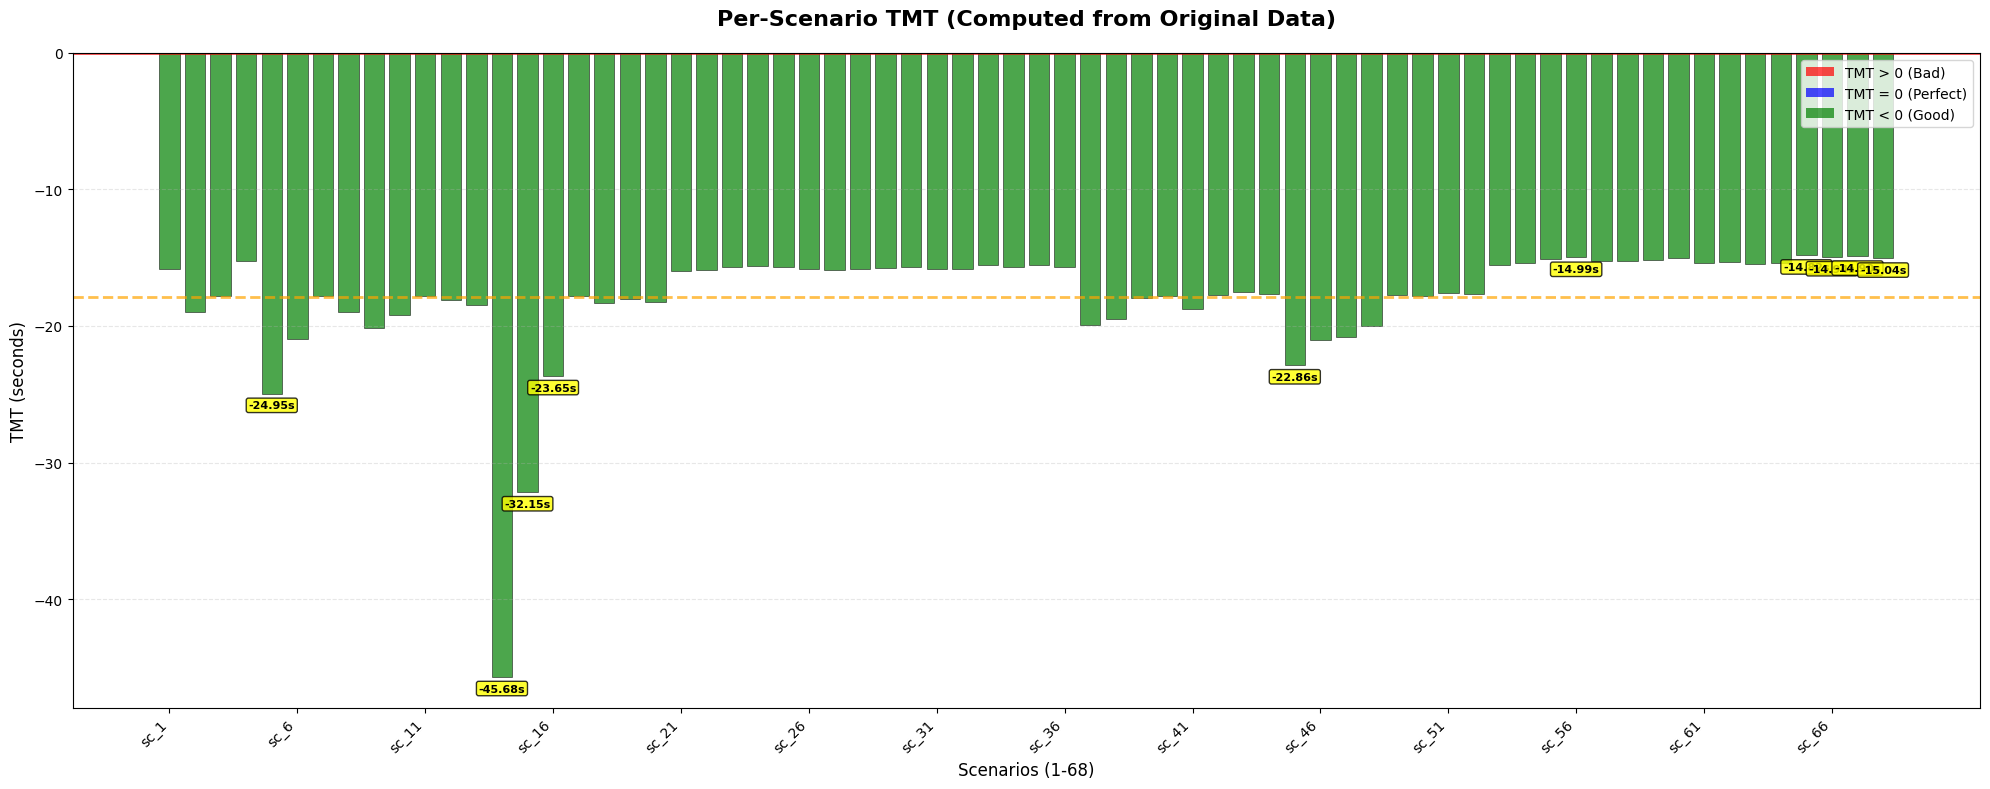


📊 CHART STATISTICS (FROM ORIGINAL DATA):
  📈 Mean TMT: -17.875s
  📈 Min TMT: -45.681s (scenario_14)
  📈 Max TMT: -14.815s (scenario_65)
  📈 Scenarios with TMT = 0: 0
  📈 Scenarios with TMT > 0: 0
  📈 Scenarios with TMT < 0: 68


In [4]:
# Crear gráfica individual del TMT por escenario (calculado desde datos originales)
if df is not None and 'TMT' in df.columns:
    # Configurar la figura
    plt.figure(figsize=(20, 8))
    
    # Sort data by scenario number
    df_plot = df.copy()
    df_plot['scenario_num'] = df_plot['Scenario'].str.extract('(\d+)').astype(int)
    df_plot = df_plot.sort_values('scenario_num')
    
    # Crear gráfica de barras con colores según el valor de TMT
    colors = ['red' if x > 0 else 'green' if x < 0 else 'blue' for x in df_plot['TMT']]
    bars = plt.bar(range(len(df_plot)), df_plot['TMT'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Customize chart
    plt.title('Per-Scenario TMT (Computed from Original Data)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Scenarios (1-68)', fontsize=12)
    plt.ylabel('TMT (seconds)', fontsize=12)
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Configure X-axis labels (show every 5 scenarios)
    x_labels = [f"sc_{i}" for i in df_plot['scenario_num']]
    plt.xticks(range(0, len(df_plot), 5), 
               [x_labels[i] for i in range(0, len(df_plot), 5)], 
               rotation=45, ha='right')
    
    # Add horizontal line at TMT = 0
    plt.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=2, 
                label='TMT = 0 (Perfect Coordination)')
    
    # Add values on bars (only for extreme values)
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        tmt_val = row['TMT']
        scenario = row['Scenario']
        
        # Show value if extreme (top 5 worst or best)
        if tmt_val in df_plot['TMT'].nlargest(5).values or tmt_val in df_plot['TMT'].nsmallest(5).values:
            plt.text(i, tmt_val + (0.5 if tmt_val >= 0 else -0.5), 
                    f'{tmt_val:.2f}s', 
                    ha='center', va='bottom' if tmt_val >= 0 else 'top',
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='yellow', alpha=0.8))
    
    # Add statistics to chart
    mean_tmt = df_plot['TMT'].mean()
    plt.axhline(y=mean_tmt, color='orange', linestyle='--', alpha=0.7, linewidth=2, 
                label=f'Mean: {mean_tmt:.3f}s')
    
    # Add color legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.7, label='TMT > 0 (Bad)'),
        Patch(facecolor='blue', alpha=0.7, label='TMT = 0 (Perfect)'),
        Patch(facecolor='green', alpha=0.7, label='TMT < 0 (Good)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Show additional statistics
    print(f"\n📊 CHART STATISTICS (FROM ORIGINAL DATA):")
    print(f"  📈 Mean TMT: {mean_tmt:.3f}s")
    print(f"  📈 Min TMT: {df_plot['TMT'].min():.3f}s (scenario_{df_plot.loc[df_plot['TMT'].idxmin(), 'scenario_num']})")
    print(f"  📈 Max TMT: {df_plot['TMT'].max():.3f}s (scenario_{df_plot.loc[df_plot['TMT'].idxmax(), 'scenario_num']})")
    print(f"  📈 Scenarios with TMT = 0: {len(df_plot[df_plot['TMT'] == 0])}")
    print(f"  📈 Scenarios with TMT > 0: {len(df_plot[df_plot['TMT'] > 0])}")
    print(f"  📈 Scenarios with TMT < 0: {len(df_plot[df_plot['TMT'] < 0])}")
    
    # Show problematic scenarios
    problematic = df_plot[df_plot['TMT'] > 0].sort_values('TMT', ascending=False)
    if len(problematic) > 0:
        print(f"\n🚨 PROBLEMATIC SCENARIOS (TMT > 0):")
        for idx, row in problematic.head(3).iterrows():
            print(f"  {row['Scenario']}: TMT={row['TMT']:.3f}s, Coord={row['Coordination (%)']:.1f}%")
    
else:
    print("⚠️ Cannot create charts: data not available or TMT column missing")


## 3️⃣ TMT Visualization by Scenario

### 📈 Chart 1: TMT Before vs After by Scenario
This chart shows the direct comparison of TMT (Total Miscoordination Time) for each of the 68 scenarios, before and after genetic algorithm optimization. It allows visual identification of which scenarios had the greatest improvements.


In [5]:
# This section was moved to a separate notebook
print("📊 BEFORE/AFTER COMPARISON CHARTS:")
print("=" * 50)
print("Before/after comparison charts are now in:")
print("📄 03.tmt_analysis_comparison_before_after.ipynb")
print("Continuing with additional TMT analysis...")


📊 BEFORE/AFTER COMPARISON CHARTS:
Before/after comparison charts are now in:
📄 03.tmt_analysis_comparison_before_after.ipynb
Continuing with additional TMT analysis...


## 2.3 📊 TMT Distribution Analysis

### Additional charts for deep TMT analysis


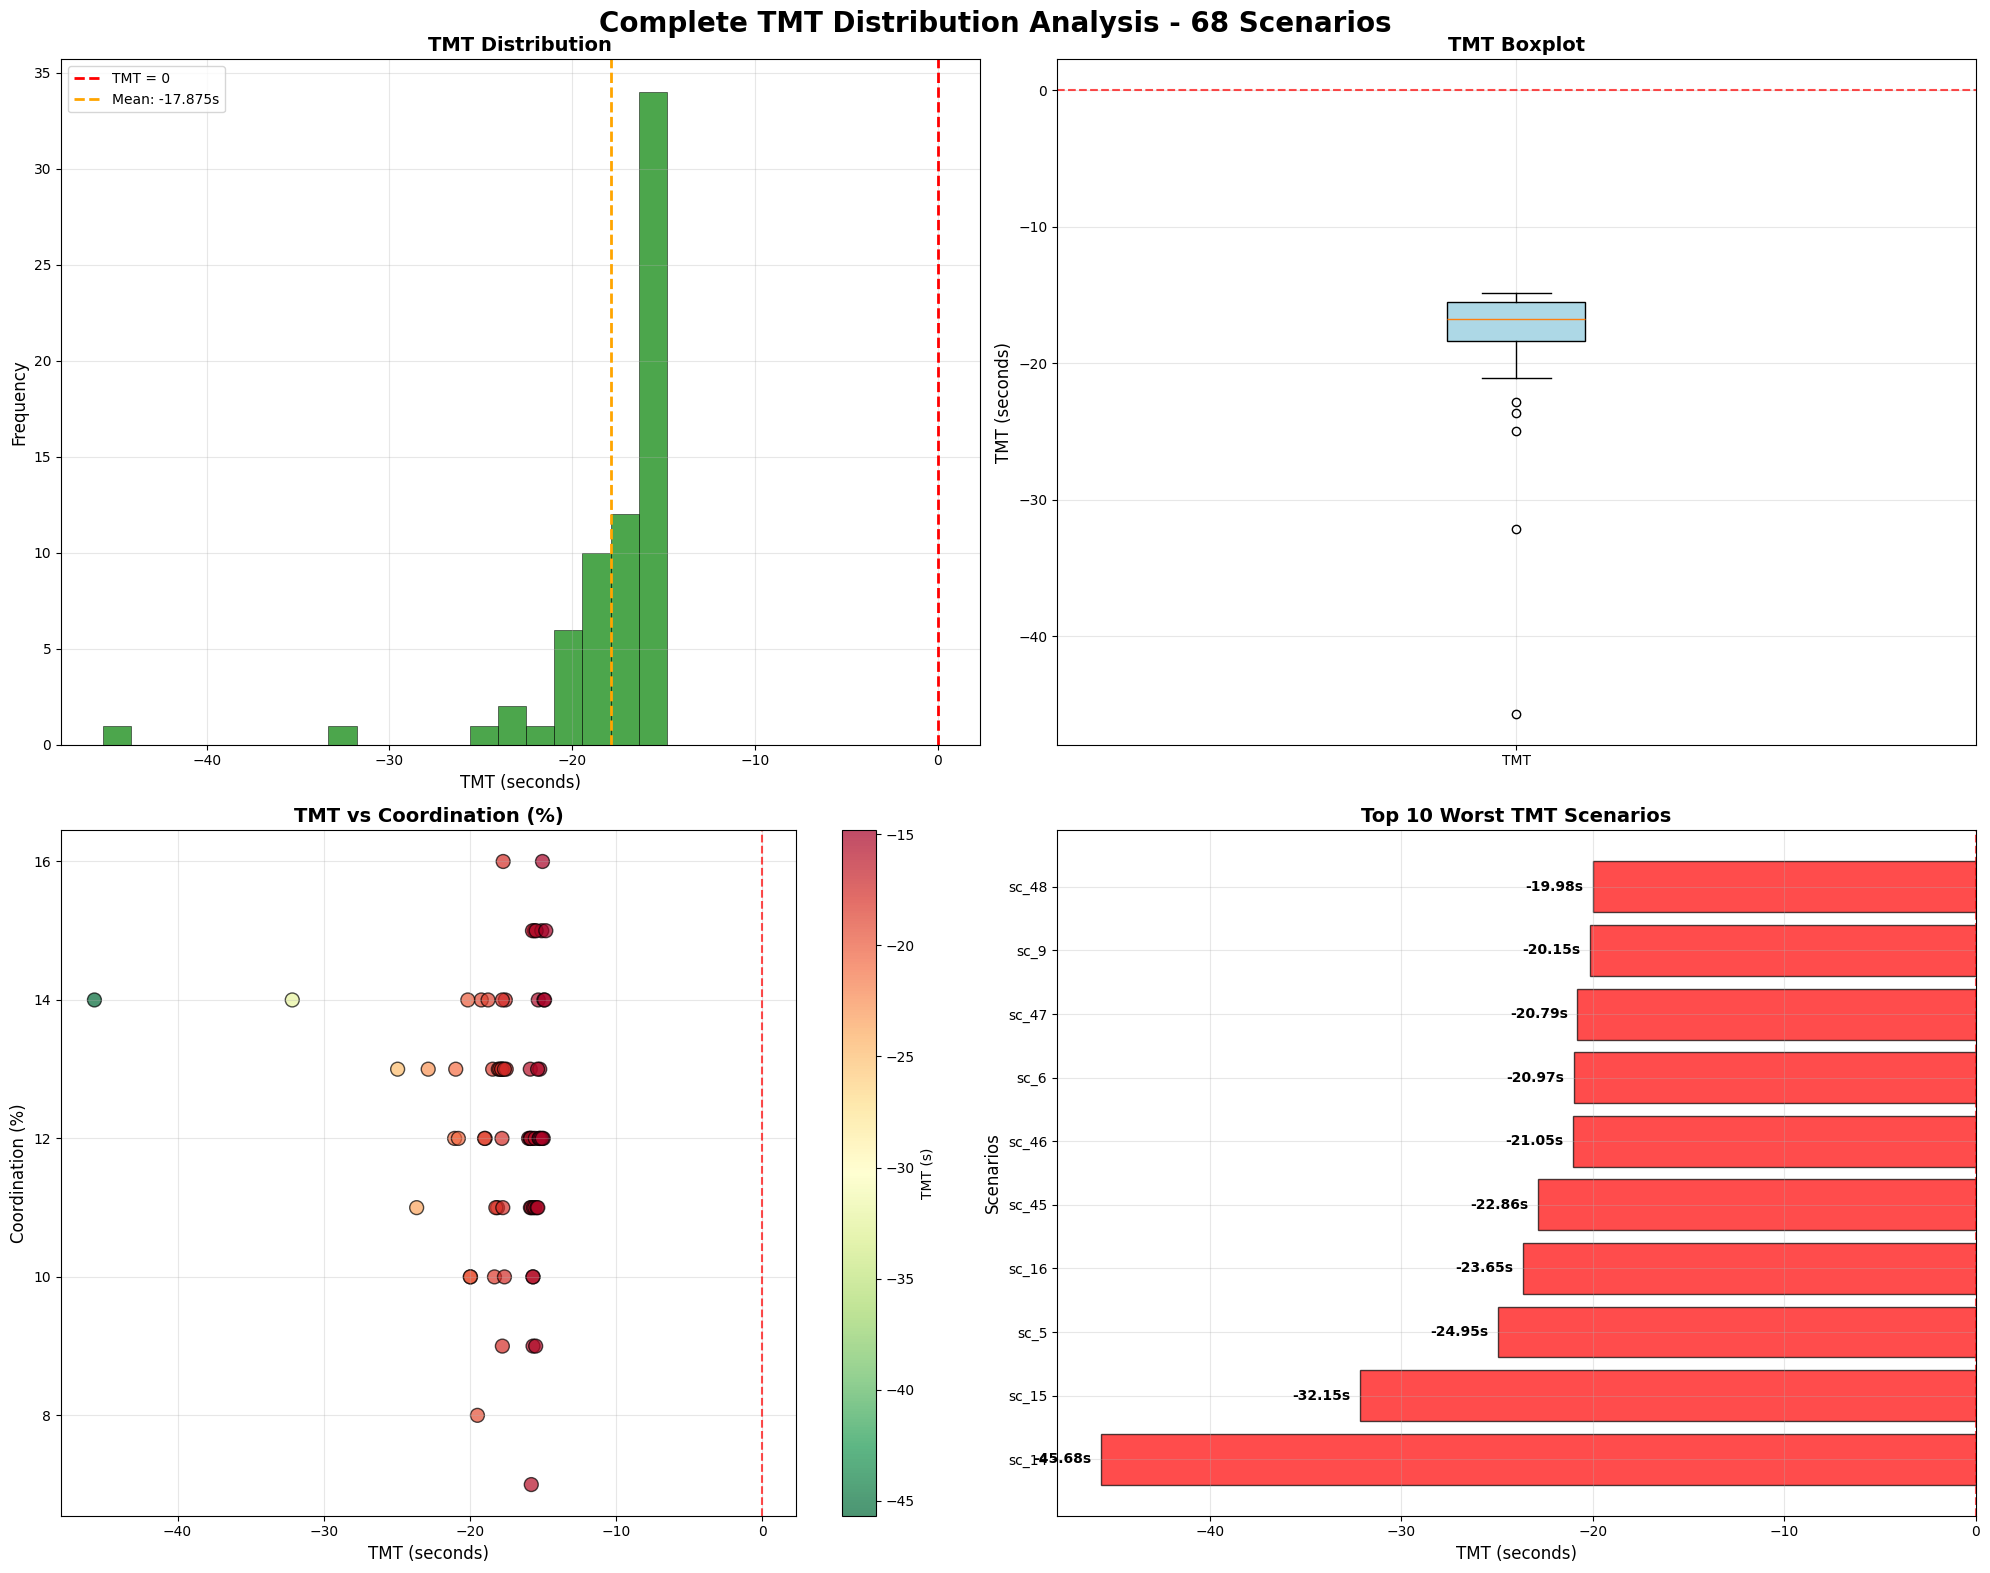


📊 TMT DISTRIBUTION ANALYSIS:
  📈 TMT Range: -45.681s to -14.815s
  📈 Standard Deviation: 4.466s
  📈 Coefficient of Variation: 25.0%
  📈 Interquartile Range: 2.823s

📊 TMT PERCENTILES:
  📈 P10: -20.849s
  📈 P25: -18.356s
  📈 P50: -16.757s
  📈 P75: -15.533s
  📈 P90: -15.141s


In [6]:
# Create multiple charts for complete TMT analysis
if df is not None and 'TMT' in df.columns:
    
    # Configure subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Complete TMT Distribution Analysis - 68 Scenarios', fontsize=20, fontweight='bold')
    
    # 1. TMT distribution histogram
    ax1 = axes[0, 0]
    n, bins, patches = ax1.hist(df['TMT'], bins=20, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Color bars by value
    for i, (patch, bin_val) in enumerate(zip(patches, bins[:-1])):
        if bin_val > 0:
            patch.set_facecolor('red')
        elif bin_val < 0:
            patch.set_facecolor('green')
        else:
            patch.set_facecolor('blue')
    
    ax1.set_title('TMT Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('TMT (seconds)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='TMT = 0')
    ax1.axvline(x=df['TMT'].mean(), color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {df["TMT"].mean():.3f}s')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. TMT boxplot
    ax2 = axes[0, 1]
    box_plot = ax2.boxplot(df['TMT'], patch_artist=True, labels=['TMT'])
    box_plot['boxes'][0].set_facecolor('lightblue')
    ax2.set_title('TMT Boxplot', fontsize=14, fontweight='bold')
    ax2.set_ylabel('TMT (seconds)', fontsize=12)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)
    
    # 3. Scatter plot: TMT vs Coordination
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df['TMT'], df['Coordination (%)'], 
                         c=df['TMT'], cmap='RdYlGn_r', alpha=0.7, s=100, edgecolors='black')
    ax3.set_title('TMT vs Coordination (%)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('TMT (seconds)', fontsize=12)
    ax3.set_ylabel('Coordination (%)', fontsize=12)
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='TMT (s)')
    
    # 4. Bar chart: Top 10 worst scenarios
    ax4 = axes[1, 1]
    worst_10 = df.nsmallest(10, 'TMT')  # Most negative (worst)
    bars = ax4.barh(range(len(worst_10)), worst_10['TMT'], 
                   color='red', alpha=0.7, edgecolor='black')
    ax4.set_title('Top 10 Worst TMT Scenarios', fontsize=14, fontweight='bold')
    ax4.set_xlabel('TMT (seconds)', fontsize=12)
    ax4.set_ylabel('Scenarios', fontsize=12)
    ax4.set_yticks(range(len(worst_10)))
    ax4.set_yticklabels([f"sc_{row['Scenario'].split('_')[1]}" for _, row in worst_10.iterrows()])
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax4.grid(True, alpha=0.3)
    
    # Add values on bars
    for i, (idx, row) in enumerate(worst_10.iterrows()):
        ax4.text(row['TMT'] - 0.5, i, f'{row["TMT"]:.2f}s', 
                va='center', ha='right', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print(f"\n📊 TMT DISTRIBUTION ANALYSIS:")
    print(f"  📈 TMT Range: {df['TMT'].min():.3f}s to {df['TMT'].max():.3f}s")
    print(f"  📈 Standard Deviation: {df['TMT'].std():.3f}s")
    print(f"  📈 Coefficient of Variation: {(df['TMT'].std()/abs(df['TMT'].mean())*100):.1f}%")
    print(f"  📈 Interquartile Range: {df['TMT'].quantile(0.75) - df['TMT'].quantile(0.25):.3f}s")
    
    # Percentiles
    percentiles = [10, 25, 50, 75, 90]
    print(f"\n📊 TMT PERCENTILES:")
    for p in percentiles:
        value = df['TMT'].quantile(p/100)
        print(f"  📈 P{p}: {value:.3f}s")
    
else:
    print("⚠️ Cannot create charts: data not available")
